In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='2'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

from torchtext import data, datasets
from torchtext.vocab import Vectors
from torch.nn import init
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [4]:
import sys
sys.path.append('/home/bis/2021_SJH_detectability/DbyDeep')
from RefModel.model_CapsNet import *

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please se

# 메모
    - GPMDP training dataset은 7.5만개의 펩타이드로 구성, 반반 레이블링
    - DeepMSPeptide, CapsNet 둘다 MOps를 0, LOps를 1로 레이블링해서 학습
    - 추론할때 확률이 높을수록 디텍터블하지 않은 것임
        - DeepMSpeptide의 경우 그래서 1-확률로 바꿔서 표현 (deepMSpeptide공식깃헙 문서에 그렇게 코딩되어있음.)
        - CapsNet도 같은 학습셋을 쓰는데 MOps에 0으로 레이블 된 것 확인함

In [5]:
def tokenizer(text): # create a tokenizer function
    """
    定义分词操作
    """
    return list(text)

from torchtext import data, datasets
LABEL = data.Field(sequential=False, use_vocab=False)
TEXT = data.Field(sequential=True, tokenize=tokenizer ,fix_length=45)
train, val, test = data.TabularDataset.splits(
                                path='/home/bis/2021_SJH_detectability/DbyDeep/RefModel/2021MDPI_CapsNet/', 
                                train='train.csv',
                                validation='val.csv',
                                test='test.csv',
                                format='csv',
                                skip_header=True,
                                fields=[('Seqs', TEXT), ('Label', LABEL)])
TEXT.build_vocab(train, val, test)
n_class = 2


model = CapsuleNet()
model.to(DEVICE)
optimizer = optim.Adam(model.parameters(),lr=0.001)
model.load_state_dict(torch.load('/home/bis/2021_SJH_detectability/DbyDeep/log/model_CapsNet.pkl'))
model.eval()

CapsuleNet(
  (embedding): Embedding(22, 20)
  (lstm): LSTM(20, 40, batch_first=True)
  (conv1): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  (conv3): Conv2d(1, 256, kernel_size=(8, 8), stride=(1, 1))
  (cbamBlock): CBAMBlock(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (max_pool): AdaptiveMaxPool2d(output_size=1)
    (channel_excitation): Sequential(
      (0): Linear(in_features=256, out_features=16, bias=False)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=16, out_features=256, bias=False)
    )
    (sigmoid): Sigmoid()
    (spatial_excitation): Sequential(
      (0): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
  )
  (conv2): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
  (conv4): Conv2d(256, 256, kernel_size=(8, 8), stride=(2, 2))
  (capsule): Capsule()
)

In [6]:
df_massive=pd.read_csv('/data/2021_SJH_detectability/data_human/train.csv')
df_merge=pd.DataFrame(df_massive.peptide.unique(), columns=['peptide'])
df_merge['Drop']=True
df_hpp=pd.read_csv('/data/2021_SJH_detectability/data_human/HPP.csv')

# Cross species - Mouse

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recen

TEST Accuracy : 0.6782437034614126
TEST AUC : 0.9058055935690963
              precision    recall  f1-score   support

           0     0.9968    0.6672    0.7994   1248307
           1     0.1042    0.9474    0.1878     51018

    accuracy                         0.6782   1299325
   macro avg     0.5505    0.8073    0.4936   1299325
weighted avg     0.9617    0.6782    0.7754   1299325



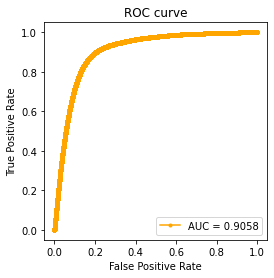

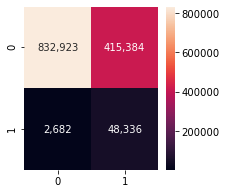

In [8]:
from torchtext import data, datasets

tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/KLife/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/KLife/test.csv'),
])
tmp=tmp.merge(df_merge, how='left')
tmp.Drop.fillna(False, inplace=True)
idxes=tmp.loc[tmp.Drop==True].index
tmp=tmp.drop(idxes, axis=0).reset_index(drop=True)
tmp=tmp.drop(['Drop'],axis=1)
tmp=tmp[['peptide', 'label']]#.drop_duplicates()

tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])
tmp.to_csv('../RefModel/2021MDPI_CapsNet/mouse_KLife.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='/home/bis/2021_SJH_detectability/DbyDeep/RefModel/2021MDPI_CapsNet/', train='mouse_KLife.csv',validation='mouse_KLife.csv',test='mouse_KLife.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 1]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))

all_pred1 = np.array(list(map(lambda x: x, np.array(all_pred1))))
all_true1 = np.array(all_true1)
all_p1 = np.array(list(map(lambda x: x, np.array(all_p1))))

auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_mouse_KLife_CapsNet_fpr.npy', fpr)
np.save('log/result_mouse_KLife_CapsNet_tpr.npy', tpr)
np.save('log/result_mouse_KLife_CapsNet_threshold.npy', threshold)
np.save('log/result_mouse_KLife_CapsNet_prob.npy', all_p1)
np.save('log/result_mouse_KLife_CapsNet_true.npy', all_true1)

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recen

TEST Accuracy : 0.6764897909420287
TEST AUC : 0.8819697384321245
              precision    recall  f1-score   support

           0     0.9955    0.6656    0.7978   1085326
           1     0.1066    0.9297    0.1912     46561

    accuracy                         0.6765   1131887
   macro avg     0.5510    0.7977    0.4945   1131887
weighted avg     0.9589    0.6765    0.7729   1131887



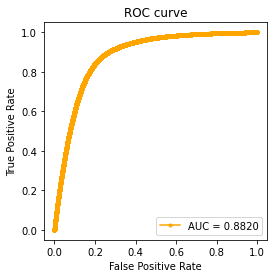

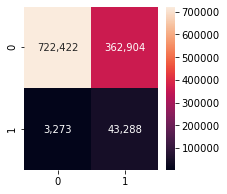

In [9]:
from torchtext import data, datasets

tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/SkeletaMuscle/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/SkeletaMuscle/test.csv'),
])
tmp=tmp.merge(df_merge, how='left')
tmp.Drop.fillna(False, inplace=True)
idxes=tmp.loc[tmp.Drop==True].index
tmp=tmp.drop(idxes, axis=0).reset_index(drop=True)
tmp=tmp.drop(['Drop'],axis=1)
tmp=tmp[['peptide', 'label']]#.drop_duplicates()

tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])
tmp.to_csv('../RefModel/2021MDPI_CapsNet/mouse_SkeletaMuscle.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='/home/bis/2021_SJH_detectability/DbyDeep/RefModel/2021MDPI_CapsNet/', train='mouse_SkeletaMuscle.csv',validation='mouse_SkeletaMuscle.csv',test='mouse_SkeletaMuscle.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 1]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))
    
all_pred1 = np.array(list(map(lambda x: x, np.array(all_pred1))))
all_true1 = np.array(all_true1)
all_p1 = np.array(list(map(lambda x: x, np.array(all_p1))))
    
auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))



plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_mouse_SkeletaMuscle_CapsNet_fpr.npy', fpr)
np.save('log/result_mouse_SkeletaMuscle_CapsNet_tpr.npy', tpr)
np.save('log/result_mouse_SkeletaMuscle_CapsNet_threshold.npy', threshold)
np.save('log/result_mouse_SkeletaMuscle_CapsNet_prob.npy', all_p1)
np.save('log/result_mouse_SkeletaMuscle_CapsNet_true.npy', all_true1)

# Cross species - Human

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recen

TEST Accuracy : 0.7055796963209473
TEST AUC : 0.8693220760094069
              precision    recall  f1-score   support

           0     0.9935    0.6990    0.8207   1363829
           1     0.0993    0.8788    0.1784     51481

    accuracy                         0.7056   1415310
   macro avg     0.5464    0.7889    0.4995   1415310
weighted avg     0.9610    0.7056    0.7973   1415310



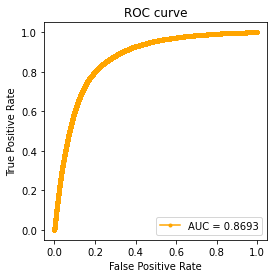

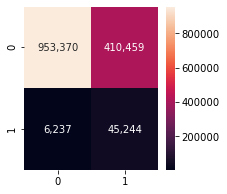

In [10]:
from torchtext import data, datasets

tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HEK293/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HEK293/test.csv'),
])
tmp=tmp.merge(df_merge, how='left')
tmp.Drop.fillna(False, inplace=True)
idxes=tmp.loc[tmp.Drop==True].index
tmp=tmp.drop(idxes, axis=0).reset_index(drop=True)
tmp=tmp.drop(['Drop'],axis=1)
tmp=tmp[['peptide', 'label']]#.drop_duplicates()

tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])
tmp.to_csv('../RefModel/2021MDPI_CapsNet/human_HEK293.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='/home/bis/2021_SJH_detectability/DbyDeep/RefModel/2021MDPI_CapsNet/', train='human_HEK293.csv',validation='human_HEK293.csv',test='human_HEK293.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 1]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))

all_pred1 = np.array(list(map(lambda x: x, np.array(all_pred1))))
all_true1 = np.array(all_true1)
all_p1 = np.array(list(map(lambda x: x, np.array(all_p1))))

auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))


plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_human_HEK293_CapsNet_fpr.npy', fpr)
np.save('log/result_human_HEK293_CapsNet_tpr.npy', tpr)
np.save('log/result_human_HEK293_CapsNet_threshold.npy', threshold)
np.save('log/result_human_HEK293_CapsNet_prob.npy', all_p1)
np.save('log/result_human_HEK293_CapsNet_true.npy', all_true1)

In [11]:
from torchtext import data, datasets

tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HmapLiver/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HmapLiver/test.csv'),
])
tmp=tmp.merge(df_merge, how='left')
tmp.Drop.fillna(False, inplace=True)
idxes=tmp.loc[tmp.Drop==True].index
tmp=tmp.drop(idxes, axis=0).reset_index(drop=True)
tmp=tmp.drop(['Drop'],axis=1)
tmp=tmp[['peptide', 'label']]#.drop_duplicates()

tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])
tmp.to_csv('../RefModel/2021MDPI_CapsNet/human_HmapLiver.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='/home/bis/2021_SJH_detectability/DbyDeep/RefModel/2021MDPI_CapsNet/', train='human_HmapLiver.csv',validation='human_HmapLiver.csv',test='human_HmapLiver.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 1]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))
    
all_pred1 = np.array(list(map(lambda x: x, np.array(all_pred1))))
all_true1 = np.array(all_true1)
all_p1 = np.array(list(map(lambda x: x, np.array(all_p1))))

auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))


plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_human_HmapLiver_CapsNet_fpr.npy', fpr)
np.save('log/result_human_HmapLiver_CapsNet_tpr.npy', tpr)
np.save('log/result_human_HmapLiver_CapsNet_threshold.npy', threshold)
np.save('log/result_human_HmapLiver_CapsNet_prob.npy', all_p1)
np.save('log/result_human_HmapLiver_CapsNet_true.npy', all_true1)

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recen

KeyboardInterrupt: 

# Cross species - Yeast

In [ ]:
from torchtext import data, datasets

tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/DelPBP1/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/DelPBP1/test.csv'),
])
tmp=tmp.merge(df_merge, how='left')
tmp.Drop.fillna(False, inplace=True)
idxes=tmp.loc[tmp.Drop==True].index
tmp=tmp.drop(idxes, axis=0).reset_index(drop=True)
tmp=tmp.drop(['Drop'],axis=1)
tmp=tmp[['peptide', 'label']]#.drop_duplicates()

tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])
tmp.to_csv('../RefModel/2021MDPI_CapsNet/yeast_DelPBP1.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='/home/bis/2021_SJH_detectability/DbyDeep/RefModel/2021MDPI_CapsNet/', train='yeast_DelPBP1.csv',validation='yeast_DelPBP1.csv',test='yeast_DelPBP1.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 1]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))
    
all_pred1 = np.array(list(map(lambda x: x, np.array(all_pred1))))
all_true1 = np.array(all_true1)
all_p1 = np.array(list(map(lambda x: x, np.array(all_p1))))

auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))


plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_yeast_DelPBP1_CapsNet_fpr.npy', fpr)
np.save('log/result_yeast_DelPBP1_CapsNet_tpr.npy', tpr)
np.save('log/result_yeast_DelPBP1_CapsNet_threshold.npy', threshold)
np.save('log/result_yeast_DelPBP1_CapsNet_prob.npy', all_p1)
np.save('log/result_yeast_DelPBP1_CapsNet_true.npy', all_true1)

In [ ]:
from torchtext import data, datasets

tmp = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/KLife/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/KLife/test.csv'),
])
tmp=tmp.merge(df_merge, how='left')
tmp.Drop.fillna(False, inplace=True)
idxes=tmp.loc[tmp.Drop==True].index
tmp=tmp.drop(idxes, axis=0).reset_index(drop=True)
tmp=tmp.drop(['Drop'],axis=1)
tmp=tmp[['peptide', 'label']]#.drop_duplicates()

tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)
tmp = tmp.rename({'peptide': 'Seq','label': 'Label'}, axis=1)
tmp['Label'] = tmp.Label.apply(lambda x: {True: 1, False:0}[x])
tmp.to_csv('../RefModel/2021MDPI_CapsNet/yeast_KLife.csv', index=False)

train1,val1,test1 = data.TabularDataset.splits(
        path='/home/bis/2021_SJH_detectability/DbyDeep/RefModel/2021MDPI_CapsNet/', train='yeast_KLife.csv',validation='yeast_KLife.csv',test='yeast_KLife.csv', format='csv',skip_header=True,
        fields=[('Seqs', TEXT), ('Label', LABEL)])
# TEXT.build_vocab(train1,val1,test1)
test_iter = data.BucketIterator(val1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 1]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))
    
all_pred1 = np.array(list(map(lambda x: x, np.array(all_pred1))))
all_true1 = np.array(all_true1)
all_p1 = np.array(list(map(lambda x: x, np.array(all_p1))))

auc = roc_auc_score(all_true1, all_p1)
acc = metrics.accuracy_score(all_true1,all_pred1)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(all_true1, all_pred1, digits=4))


plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(all_true1, all_p1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_yeast_KLife_CapsNet_fpr.npy', fpr)
np.save('log/result_yeast_KLife_CapsNet_tpr.npy', tpr)
np.save('log/result_yeast_KLife_CapsNet_threshold.npy', threshold)
np.save('log/result_yeast_KLife_CapsNet_prob.npy', all_p1)
np.save('log/result_yeast_KLife_CapsNet_true.npy', all_true1)